In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup flow and head boundary with two observations

In [6]:
from morpheus.project.types.boundaries.Observation import ObservationName
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection
from morpheus.project.types.boundaries.Boundary import FlowAndHeadBoundary
from morpheus.project.types.boundaries.FlowAndHeadObservation import ObservationId, FlowAndHeadRawDataItem, \
  FlowAndHeadObservation, Flow, Head, StartDateTime

head_and_flow_east = FlowAndHeadBoundary.from_geometry(
  name=BoundaryName('flow_and_head_east'),
  geometry=LineString([
    (13.92499, 50.966),
    (13.92499, 50.964),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    FlowAndHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92499, 50.966)),
      data=[
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
          flow=Flow.from_float(100),
          head=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 2, 1)),
          flow=Flow.from_float(110),
          head=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          flow=Flow.from_float(140),
          head=None
        ),
      ]
    ),
    FlowAndHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92499, 50.964)),
      data=[
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
          flow=Flow.from_float(200),
          head=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 2, 1)),
          flow=Flow.from_float(210),
          head=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          flow=Flow.from_float(240),
          head=None
        ),
      ]
    ),
  ]
)

head_and_flow_west = FlowAndHeadBoundary.from_geometry(
  name=BoundaryName('flow_and_head_west'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92004, 50.96599),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    FlowAndHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92004, 50.96599)),
      data=[
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
          head=Head.from_float(300),
          flow=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          head=Head.from_float(300),
          flow=None
        ),
      ]
    ),
    FlowAndHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92004, 50.96401)),
      data=[
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
          head=Head.from_float(400),
          flow=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          head=Head.from_float(400),
          flow=None
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(head_and_flow_west)
boundary_collection.add_boundary(head_and_flow_east)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(head_and_flow_east.as_geojson()))
m.add_child(folium.GeoJson(head_and_flow_east.affected_cells.to_geojson(grid).as_geojson()))
for observation in head_and_flow_east.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.add_child(folium.GeoJson(head_and_flow_west.as_geojson()))
m.add_child(folium.GeoJson(head_and_flow_west.affected_cells.to_geojson(grid).as_geojson()))
for observation in head_and_flow_west.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))
m.fit_bounds(m.get_bounds())
m

In [7]:
from morpheus.project.types.boundaries.Boundary import BoundaryType

len(model.boundaries.get_boundaries_of_type(BoundaryType.flow_and_head))

2

In [8]:
head_and_flow_east.observations

[FlowAndHeadObservation(observation_id=ObservationId(value='e48db0d5-1aba-4d45-be70-019c1b91483e'), observation_name=ObservationName(value='Observation Point 1'), geometry=Point(coordinates=(13.92499, 50.966), type='Point'), data=[FlowAndHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2020, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)), flow=Flow(value=100), head=None), FlowAndHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2020, 2, 1, 0, 0, tzinfo=datetime.timezone.utc)), flow=Flow(value=110), head=None), FlowAndHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2021, 12, 31, 0, 0, tzinfo=datetime.timezone.utc)), flow=Flow(value=140), head=None)]),
 FlowAndHeadObservation(observation_id=ObservationId(value='ac2cb9b4-c935-4b6c-86e0-adc5c9b393a6'), observation_name=ObservationName(value='Observation Point 1'), geometry=Point(coordinates=(13.92499, 50.964), type='Point'), data=[FlowAndHeadRawDataItem(date_time=StartDateTime(value=datetime.datetim

In [9]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.FhbPackageMapper import \
  calculate_fhb_boundary_stress_period_data

result = calculate_fhb_boundary_stress_period_data(model)
result.to_dict()

{'date_times': [StartDateTime(value=datetime.datetime(2020, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)),
  StartDateTime(value=datetime.datetime(2020, 2, 1, 0, 0, tzinfo=datetime.timezone.utc))],
 'total_times': [0.0, 31.0],
 'flow_data': [TimeStepValuesItem(layer=0, row=0, column=99, values=[100.99997868936319, 110.99997868936319]),
  TimeStepValuesItem(layer=0, row=1, column=99, values=[102.99993735985626, 112.99993735985626]),
  TimeStepValuesItem(layer=0, row=2, column=99, values=[104.99989775163911, 114.99989775163911]),
  TimeStepValuesItem(layer=0, row=3, column=99, values=[106.99985986577755, 116.99985986577755]),
  TimeStepValuesItem(layer=0, row=4, column=99, values=[108.99982370191631, 118.99982370191631]),
  TimeStepValuesItem(layer=0, row=5, column=99, values=[110.9997892600554, 120.9997892600554]),
  TimeStepValuesItem(layer=0, row=6, column=99, values=[112.99975654055007, 122.99975654055007]),
  TimeStepValuesItem(layer=0, row=7, column=99, values=[114.99972554268979, 124

## Calculate

In [10]:
from morpheus.project.infrastructure.calculation.engines.base.CalculationEngineFactory import CalculationEngineFactory
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import CalculationId

calculation_id = CalculationId.new()
calculation_profile = CalculationProfile.new(CalculationEngineType.MF2005)
engine = CalculationEngineFactory.create_engine(calculation_id=calculation_id, engine_type=calculation_profile.engine_type)
check_model_log = engine.preprocess(model, calculation_profile)
check_model_log.to_list()

['type,package,k,i,j,value,desc']

In [11]:
log, result = engine.run(model=model, calculation_profile=calculation_profile)

FloPy is using the following executable to run the model: ../../../../../../../src/backend/.venv/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf2005.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/16 19:31:39

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/16 19:31:39
 Elapsed run time:  0.158 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)


In [12]:
result

CalculationResult(type=<CalculationResultType.FAILURE: 'failure'>, message='Calculation failed', files=['mf2005.list', 'mf2005.dis', 'mf2005.nam', 'mf2005.bas', 'mf2005.lpf', 'mf2005.pcg', 'mf2005.oc', 'mf2005.hds', 'mf2005.fhb'], flow_head_results=None, flow_drawdown_results=None, flow_budget_results=None, transport_concentration_results=None, transport_budget_results=None, packages=['DIS', 'BAS6', 'FHB', 'PCG', 'LPF', 'OC'])

In [13]:
head = engine.read_flow_head(idx=0, layer=0)

In [14]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 5830870040576.0, 58308700405

In [15]:
engine.read_flow_drawdown(idx=0, layer=0)

[]

In [16]:
engine.read_flow_budget(idx=0, incremental=False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'SPECIFIED_FLOWS_IN': 2737493.5,
 'TOTAL_IN': 2737493.5,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'SPECIFIED_FLOWS_OUT': -0.0,
 'TOTAL_OUT': -0.0,
 'IN-OUT': 2737493.5,
 'PERCENT_DISCREPANCY': 200.0,
 'tslen': 0.0}

In [17]:
engine.read_flow_budget(idx=0, incremental=True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'SPECIFIED_FLOWS_IN': 7499.982,
 'TOTAL_IN': 7499.982,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'SPECIFIED_FLOWS_OUT': -0.0,
 'TOTAL_OUT': -0.0,
 'IN-OUT': 7499.982,
 'PERCENT_DISCREPANCY': 200.0,
 'tslen': 365.0}

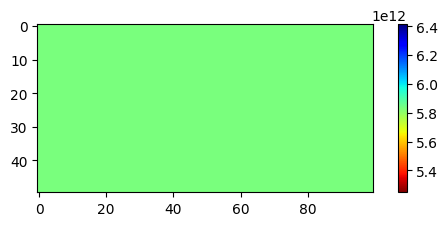

In [18]:
import matplotlib.pyplot as plt

heads = engine.read_flow_head(idx=0, layer=0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()